In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import os
from tqdm import tqdm
from sklearn import metrics
import SpatialDE

sc.set_figure_params(figsize=(6, 4))

In [2]:
def get_adata(path, meta):
    sample = path.split('/')[2].split('_')[2]
    adata = sc.read_10x_mtx(path, cache=True)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=10)
    
    adata.obs.index = [sample + '_' + name for name in adata.obs.index]
    msk = [name in meta.index for name in adata.obs.index]
    adata = adata[msk]
    adata.obs = pd.merge(adata.obs, meta, left_index=True,right_index=True)
    adata.obs['donor'] = sample
    
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata

root_path = 'data/'
rna_path = root_path + 'rna_seq/'
lst_dirs = [dname for dname in os.listdir(rna_path) if os.path.isdir(rna_path+dname) and dname.startswith('2')]

meta = pd.read_csv('data/rna_seq/metadata.csv', index_col=0)

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = rna_path + d + '/premrna_outs/filtered_feature_bc_matrix'
    tmp = get_adata(path, meta)
    adatas.append(tmp)
    del tmp
adata = adatas[0].concatenate(adatas[1:])

cc_genes = pd.read_table('data/Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = list(cc_genes['S'].dropna())
g2m_genes = list(cc_genes['G2.M'].dropna())
s_genes = adata.var_names[np.in1d(adata.var_names, s_genes)]
g2m_genes = adata.var_names[np.in1d(adata.var_names, g2m_genes)]
sc_genes = np.hstack((s_genes,g2m_genes))
se_genes = np.array([gene.rstrip() for gene in open('data/seurat_ccgenes.csv', 'r').readlines()])
cc_genes = np.unique(np.hstack((sc_genes, se_genes)))

msk = np.array([gene in cc_genes for gene in adata.var.index])
h_adata = adata[:,~msk]
c_adata = adata[:,msk]
del adata

h_adata.var['mt'] = h_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(h_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
c_adata.var['mt'] = c_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(c_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pp.normalize_total(h_adata, target_sum=1e4)
sc.pp.normalize_total(c_adata, target_sum=1e4)

sc.pp.log1p(h_adata)
sc.pp.log1p(c_adata)

sc.pp.highly_variable_genes(
    h_adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True
)

h_adata.raw = h_adata
c_adata.raw = c_adata

h_adata = h_adata[:, h_adata.var.highly_variable]

sc.pp.regress_out(h_adata, ['total_counts', 'pct_counts_mt'])
sc.pp.regress_out(c_adata, ['total_counts', 'pct_counts_mt'])


sc.pp.scale(h_adata, max_value=10)
sc.pp.scale(c_adata, max_value=10)

sc.tl.pca(h_adata, svd_solver='arpack')
sc.tl.pca(c_adata, svd_solver='arpack')

sc.pp.neighbors(h_adata)
sc.pp.neighbors(c_adata)
sc.tl.umap(h_adata)
sc.tl.umap(c_adata)

  0%|          | 0/5 [00:00<?, ?it/s]/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
100%|██████████| 5/5 [00:02<00:00,  1.90it/s]
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


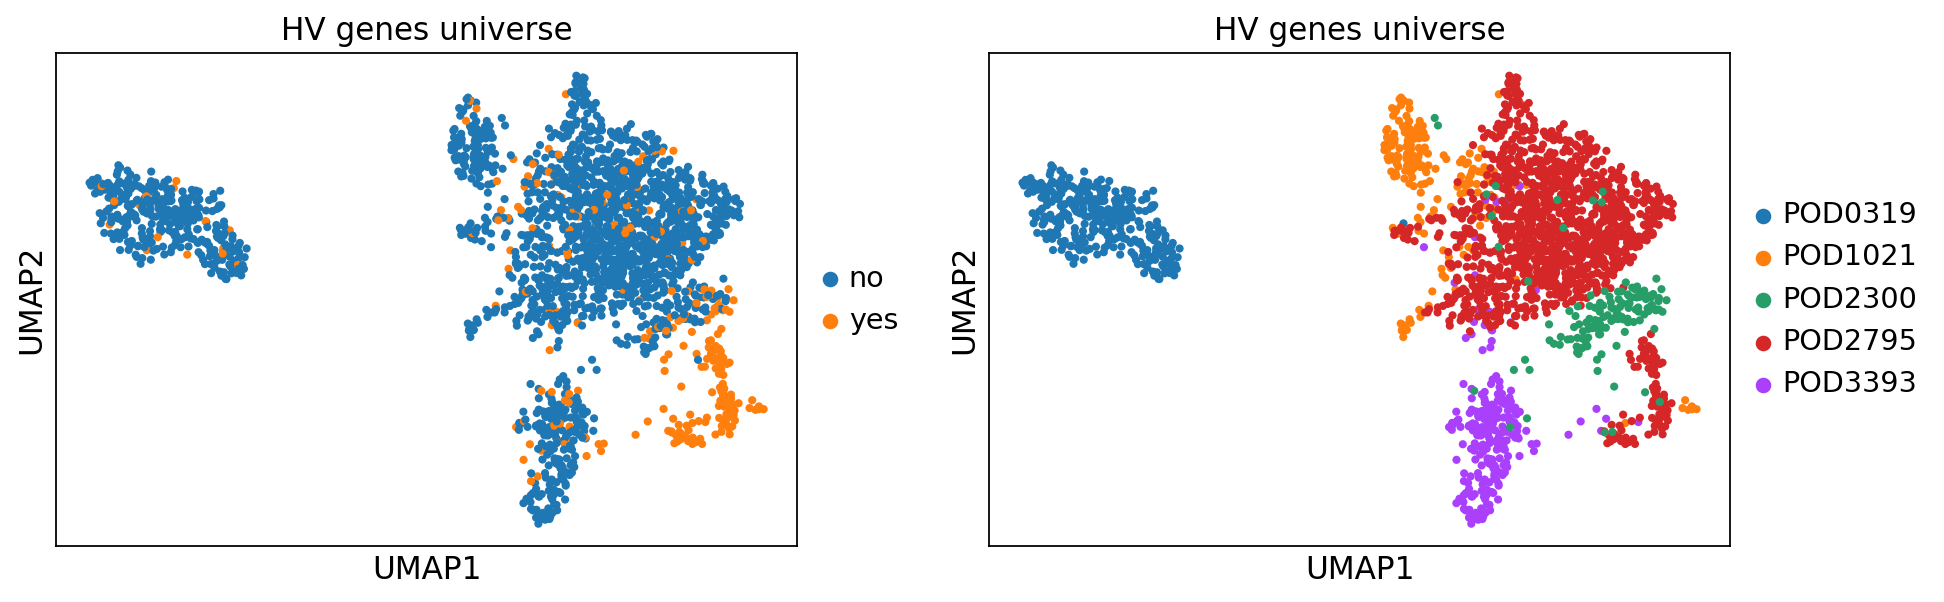

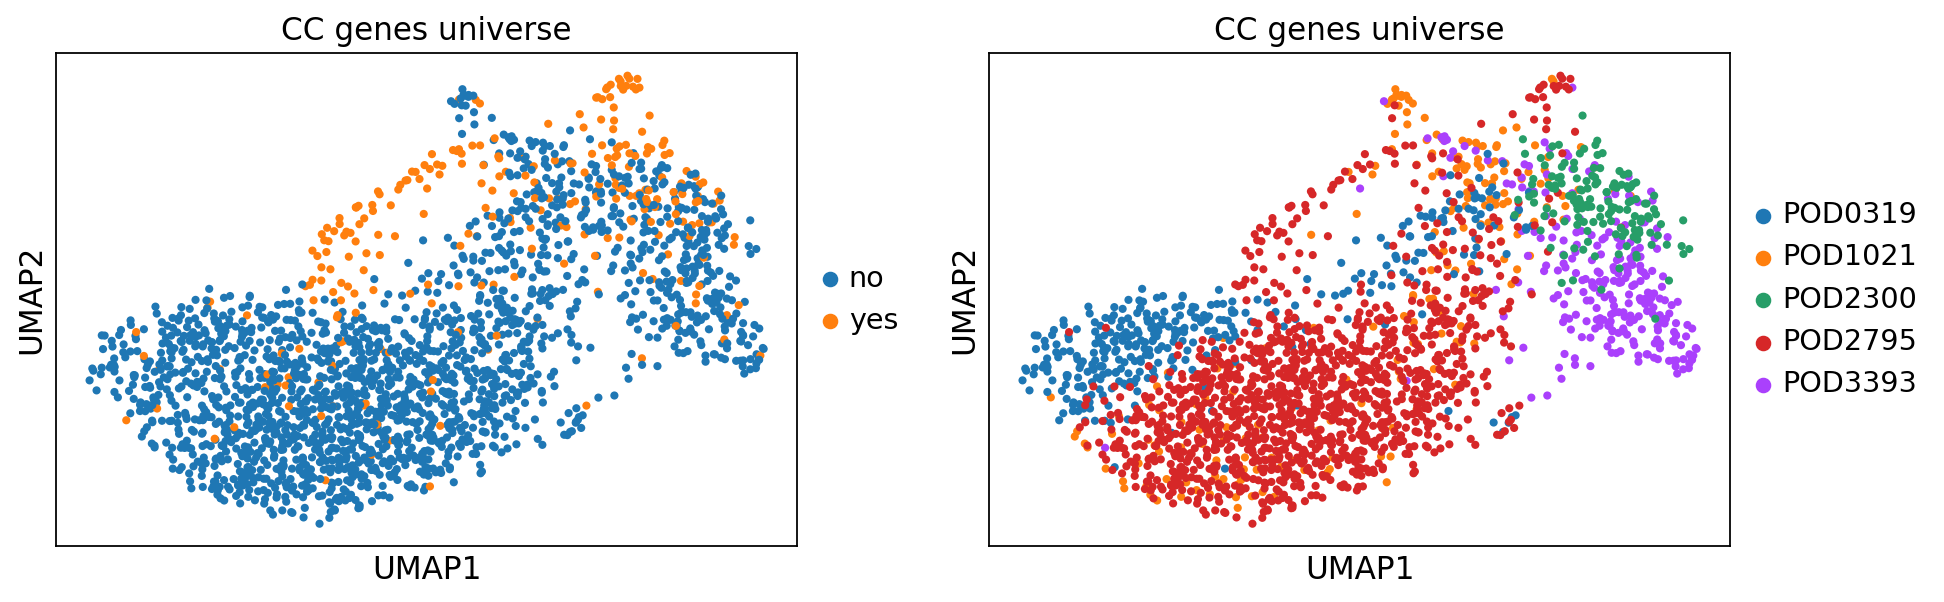

In [3]:
sc.pl.umap(h_adata, color=['cycling', 'donor'], title=['HV genes universe', 'HV genes universe'])
sc.pl.umap(c_adata, color=['cycling', 'donor'], title=['CC genes universe', 'CC genes universe'])

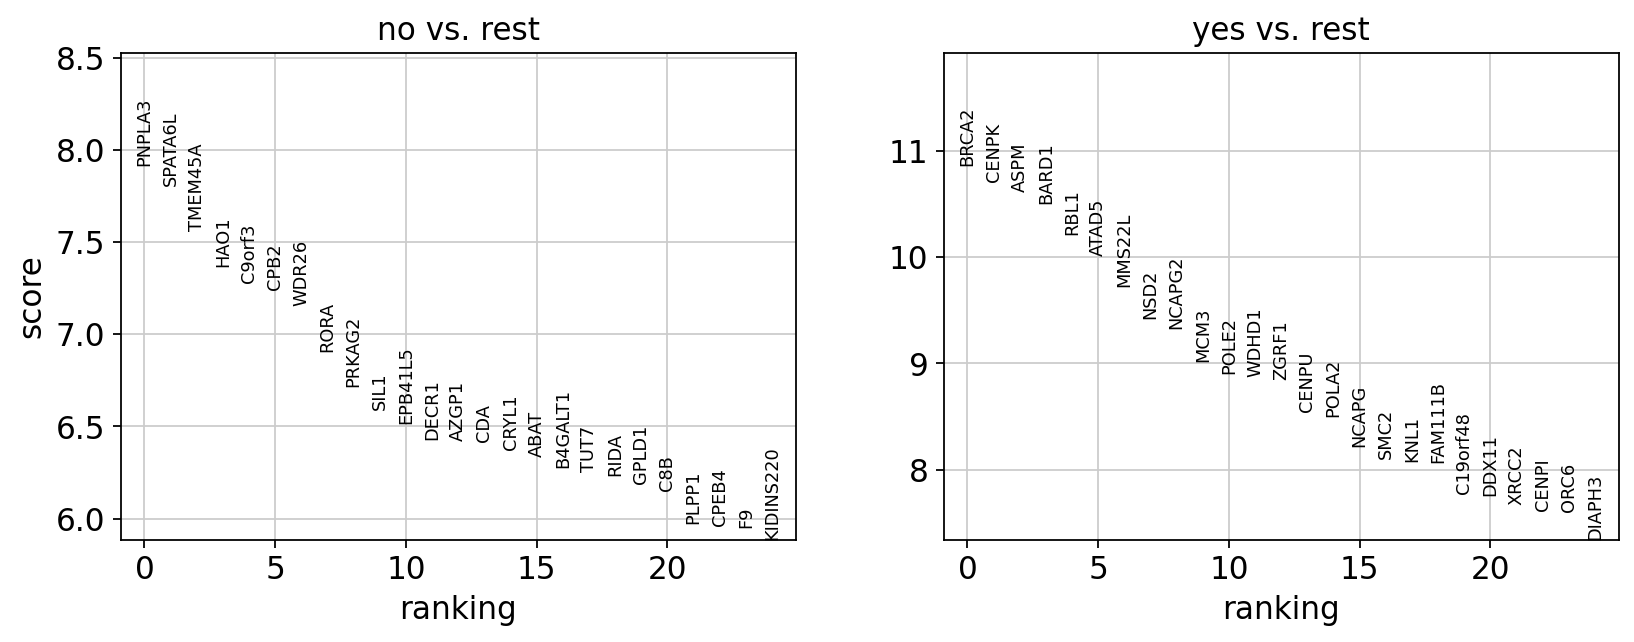

In [5]:
sc.tl.rank_genes_groups(h_adata, 'cycling', method='wilcoxon')
sc.pl.rank_genes_groups(h_adata, n_genes=25, sharey=False)

In [6]:
names = h_adata.uns['rank_genes_groups']['names']
pvals_adj = h_adata.uns['rank_genes_groups']['pvals_adj']
logfoldchanges = h_adata.uns['rank_genes_groups']['logfoldchanges']
names_no, names_yes = [x for x in zip(*names)]
pvals_adj_no, pvals_adj_yes = [x for x in zip(*pvals_adj)]
logfoldchanges_no, logfoldchanges_yes = [x for x in zip(*logfoldchanges)]

df_no = pd.DataFrame()
df_no['gene'] = names_no
df_no['pvals_adj'] = pvals_adj_no
df_no['logfoldchanges'] = logfoldchanges_no
df_no = df_no[df_no.logfoldchanges > 0]

df_yes = pd.DataFrame()
df_yes['gene'] = names_yes
df_yes['pvals_adj'] = pvals_adj_yes
df_yes['logfoldchanges'] = logfoldchanges_yes
df_yes = df_yes[df_yes.logfoldchanges > 0]

In [7]:
df_yes.head(23)

gene     pvals_adj  logfoldchanges
0      BRCA2  3.532289e-24        3.697952
1      CENPK  9.051770e-24        4.137480
2       ASPM  1.801326e-23        4.331597
3      BARD1  4.530009e-23        3.147184
4       RBL1  6.992341e-22        2.840541
5      ATAD5  4.427099e-21        3.347773
6     MMS22L  7.209542e-20        2.463258
7       NSD2  1.155242e-18        1.231990
8     NCAPG2  2.443632e-18        2.876961
9       MCM3  4.009730e-17        2.772866
10     POLE2  9.665061e-17        2.775033
11     WDHD1  1.200919e-16        2.909312
12     ZGRF1  1.351772e-16        2.560830
13     CENPU  1.799027e-15        4.189896
14     POLA2  2.551121e-15        2.619396
15     NCAPG  2.712931e-14        6.314616
16      SMC2  6.156499e-14        2.798276
17      KNL1  7.482338e-14        2.199113
18   FAM111B  7.723514e-14        6.589642
19  C19orf48  7.134359e-13        2.292982
20     DDX11  7.769241e-13        1.802832
21     XRCC2  1.473740e-12        3.319978
22     CENPI  2.078868e-12        4.988318

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


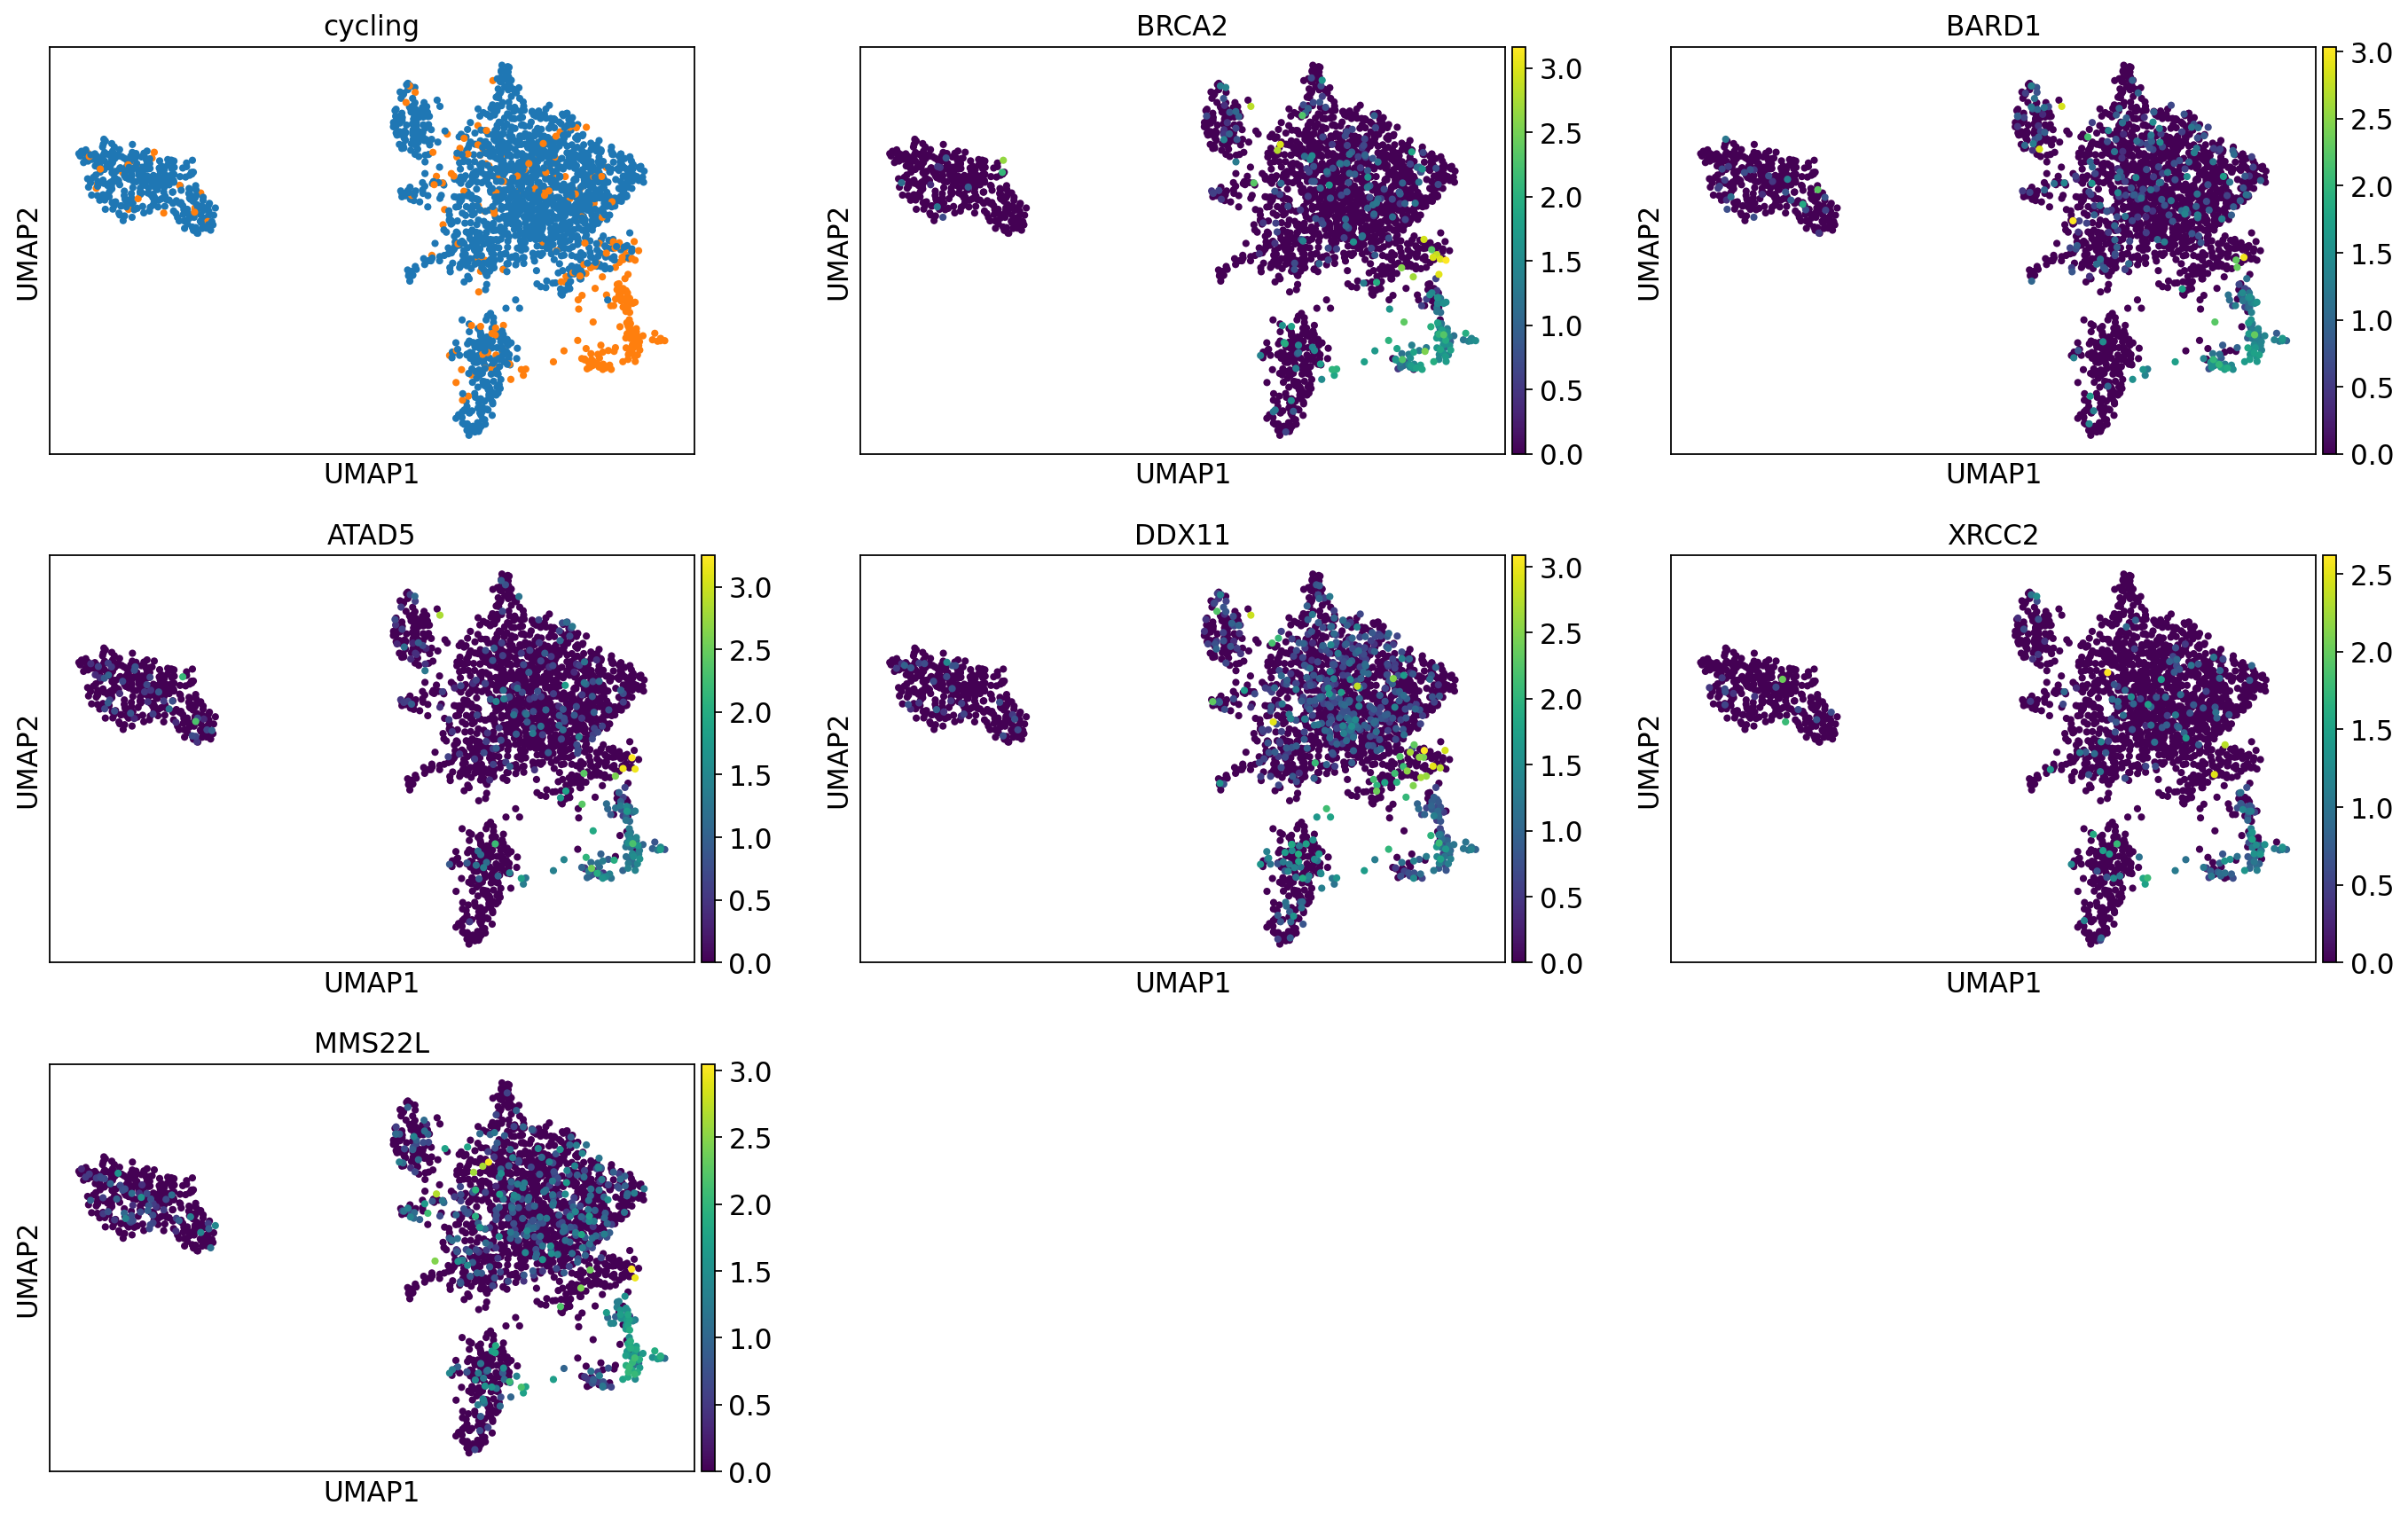

In [8]:
# DNA repair
sc.pl.umap(h_adata, color=['cycling', 'BRCA2', 'BARD1', 'ATAD5', 'DDX11', 'XRCC2', 'MMS22L', ], ncols=3, legend_loc=None)

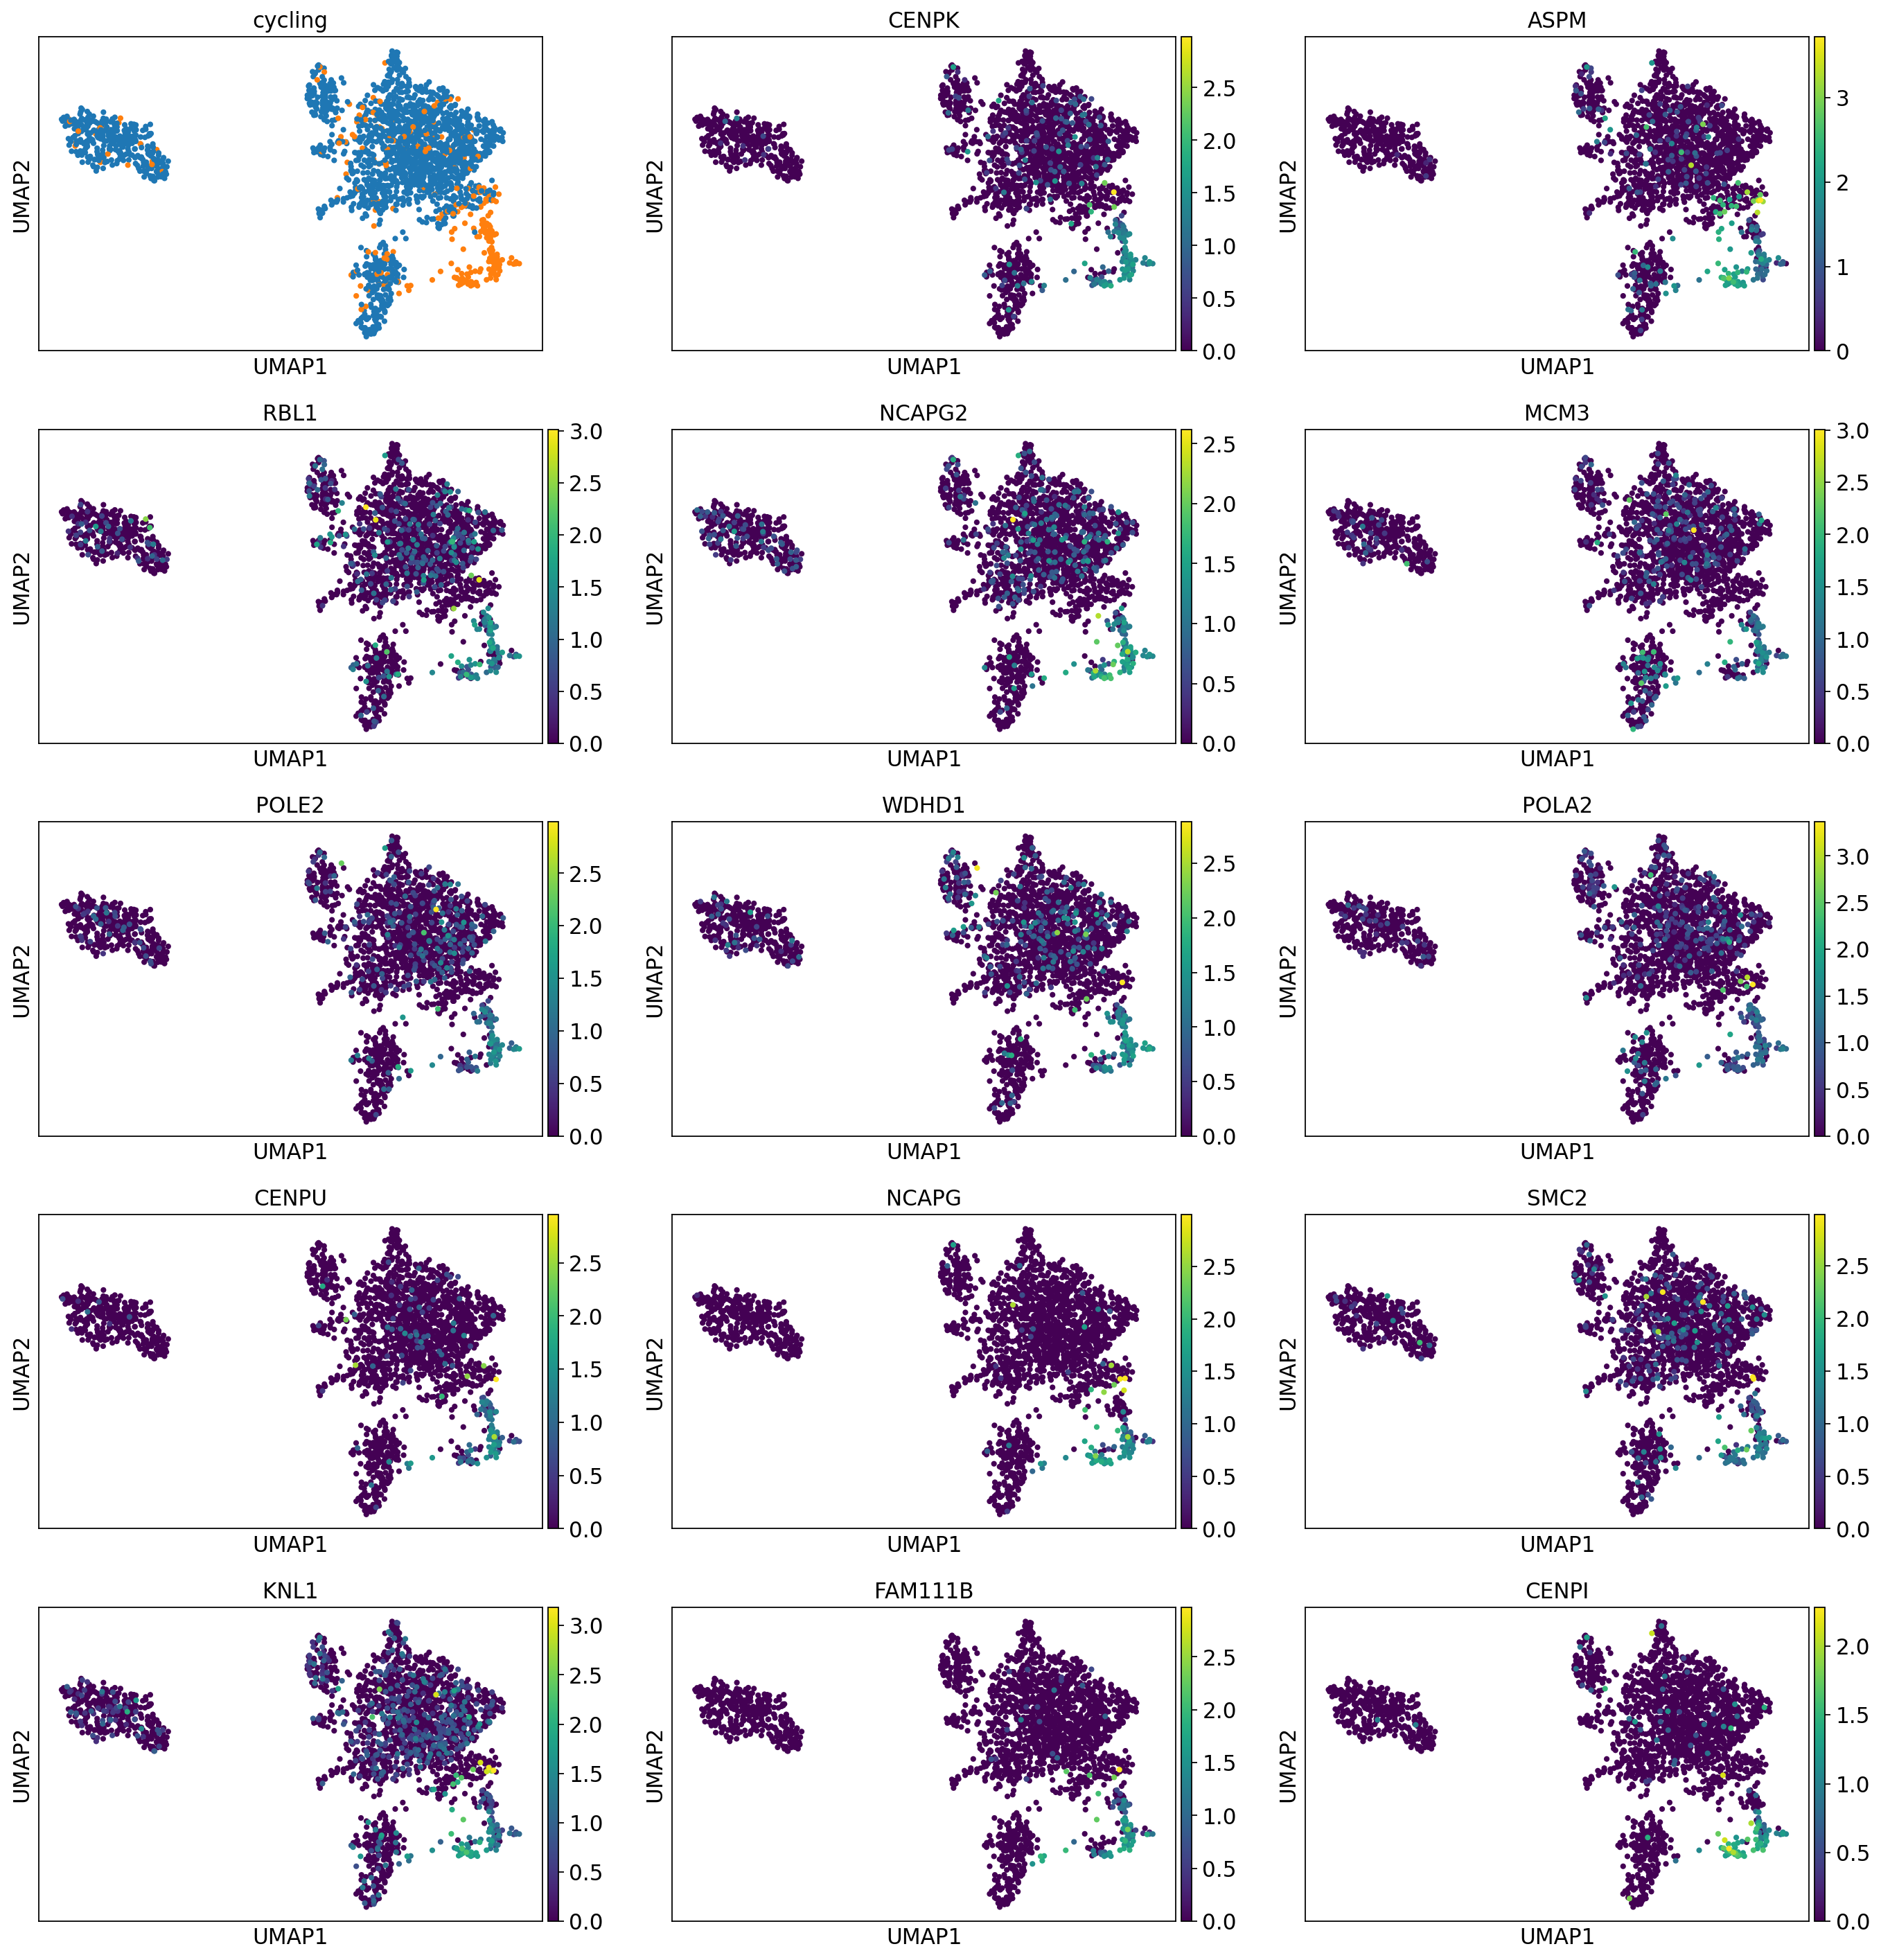

In [9]:
# Cycling genes
sc.pl.umap(h_adata, color=['cycling', 'CENPK', 'ASPM', 'RBL1', 'NCAPG2', 'MCM3', 'POLE2', 'WDHD1', 'POLA2', 'CENPU', 'NCAPG', 'SMC2', 'KNL1', 'FAM111B', 'CENPI'], ncols=3, legend_loc=None)

# Meta-analysis

In [10]:
adatas = []
for donor in np.unique(h_adata.obs.donor):
    tmp = h_adata[h_adata.obs.donor == donor]
    sc.tl.rank_genes_groups(tmp, 'cycling', method='wilcoxon')
    adatas.append(tmp)
    del tmp

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


In [11]:
def extract_de(adata):
    names = adata.uns['rank_genes_groups']['names']
    pvals_adj = adata.uns['rank_genes_groups']['pvals_adj']
    logfoldchanges = adata.uns['rank_genes_groups']['logfoldchanges']

    names_no, names_yes = [x for x in zip(*names)]
    pvals_adj_no, pvals_adj_yes = [x for x in zip(*pvals_adj)]
    logfoldchanges_no, logfoldchanges_yes = [x for x in zip(*logfoldchanges)]

    df = pd.DataFrame()
    df['gene'] = names_yes
    df['pvals_adj'] = pvals_adj_yes
    df['logfoldchanges'] = logfoldchanges_yes

    return df.head(500)[['gene', 'logfoldchanges']]

def get_ct_scores(adata, de):
    markers = np.array(de['gene'])
    scores = np.array(de['logfoldchanges'])

    msk = np.array([np.where(adata.var.index == gene)[0][0] for gene in markers])
    X = adata.X[:, msk]

    ct = X @ scores
    
    return ct

In [12]:
auc_arr = np.zeros((len(adatas), len(adatas)))

for i in range(len(adatas)):
    adata = adatas[i]
    for j in range(len(adatas)):
        de = extract_de(adatas[j])
        ct = get_ct_scores(adata, de)
        y = np.array(adata.obs.cycling == 'yes') * 1
        fpr, tpr, thresholds = metrics.roc_curve(y, ct)
        auc = metrics.auc(fpr, tpr)
        auc_arr[i, j] = auc

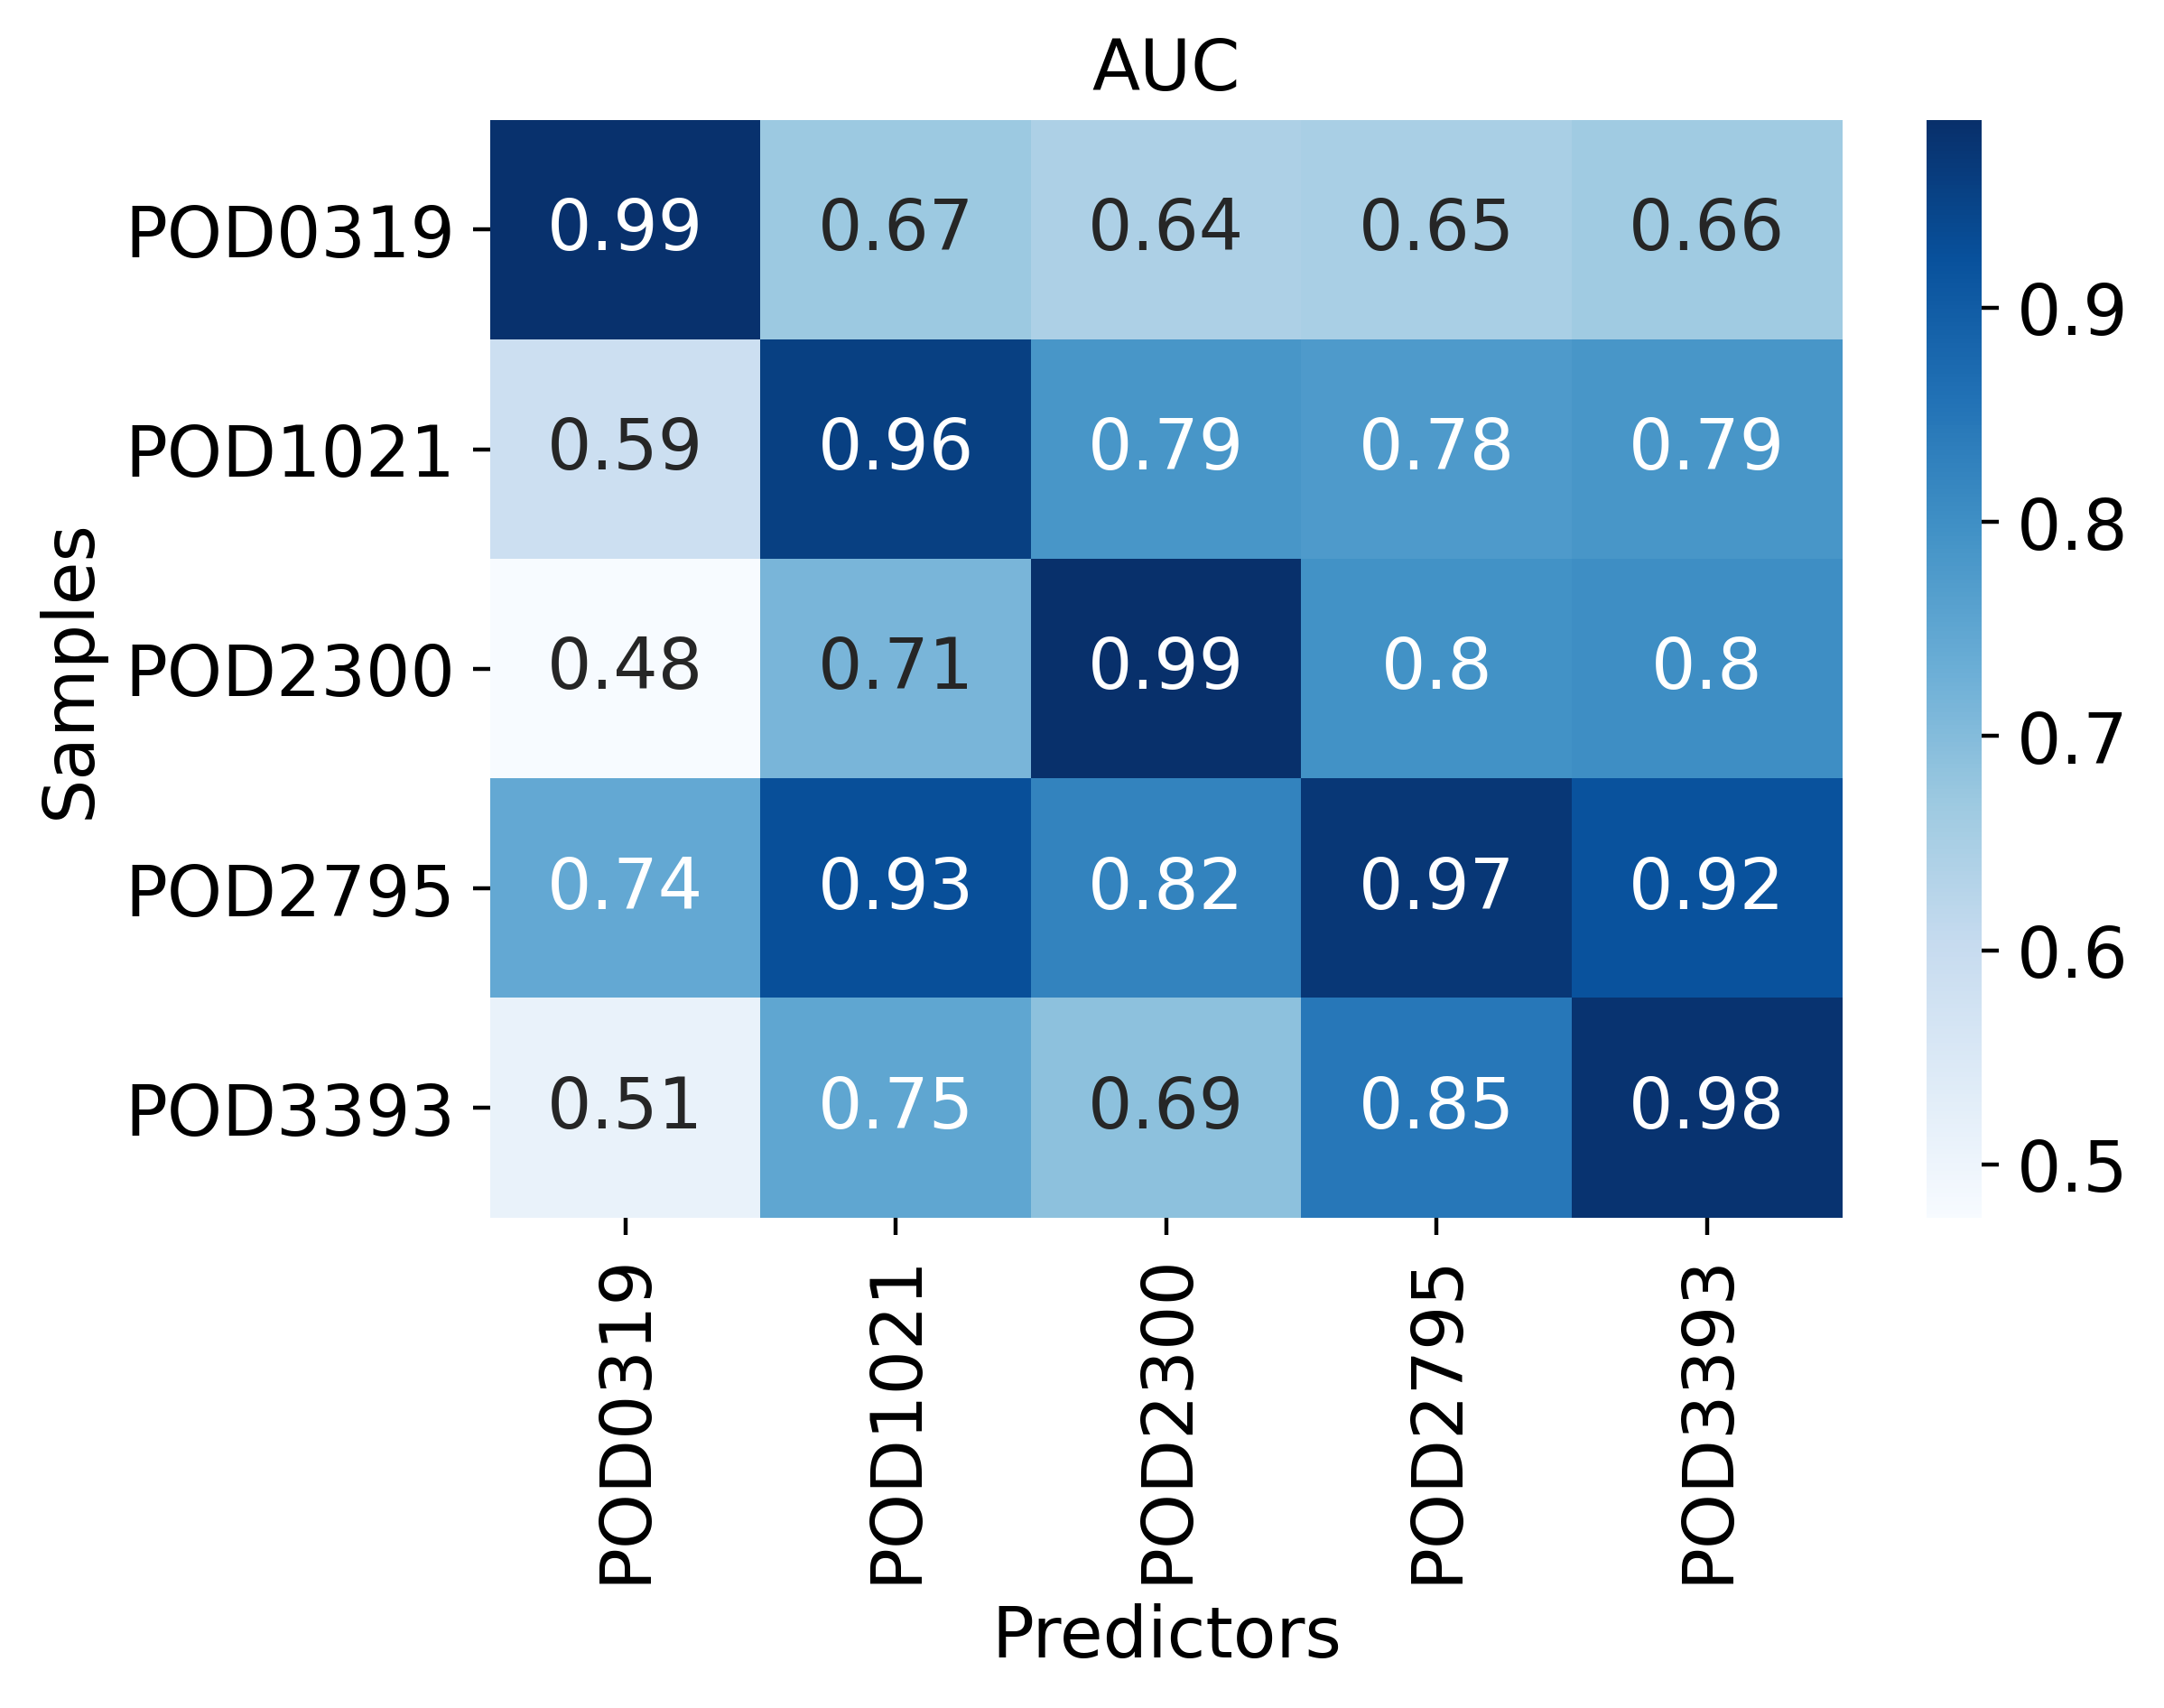

In [13]:
labels = np.unique(h_adata.obs.donor)

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=200)

plt.title('AUC')
sns.heatmap(auc_arr, annot=True, xticklabels=labels, yticklabels=labels, ax=ax, cmap='Blues')
plt.xlabel('Predictors')
plt.ylabel('Samples')
plt.show()

# Dorothea

In [51]:
import anndata

df = pd.read_csv('data/rna_seq/dorothea.csv', index_col=0)
meta = pd.read_csv('data/rna_seq/metadata.csv', index_col=0)
meta['donor'] = [name.split('_')[0] for name in meta.index]


adata = anndata.AnnData(df)
adata.obs = pd.merge(adata.obs, meta, left_index=True,right_index=True)
sorted_idx = np.argsort(h_adata.obs.index)
adata.obsm['X_umap'] = h_adata.obsm['X_umap'][sorted_idx]

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'broad_celltype' as categorical
... storing 'cycling' as categorical
... storing 'donor' as categorical


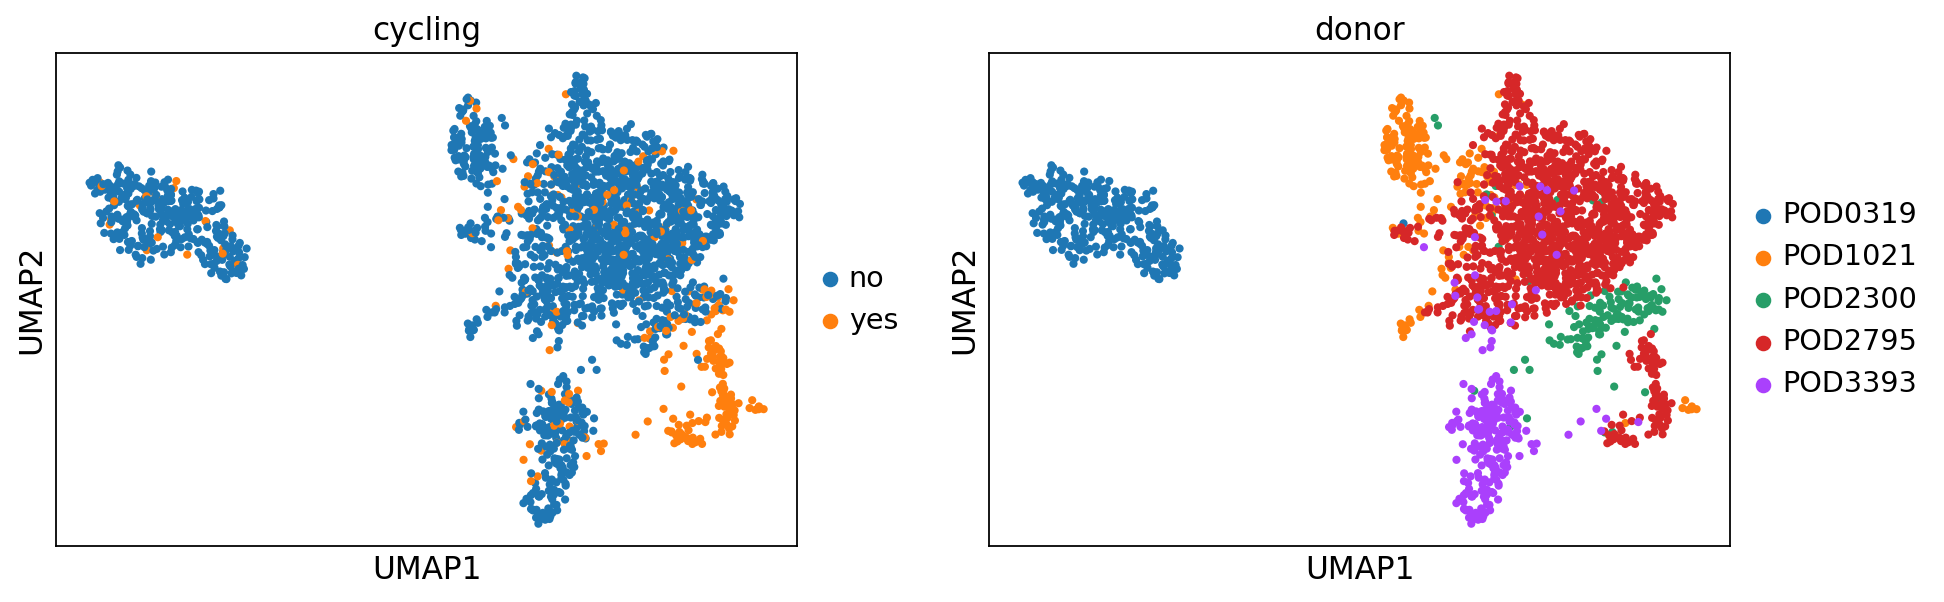

In [52]:
sc.pl.umap(adata, color=['cycling', 'donor'])

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


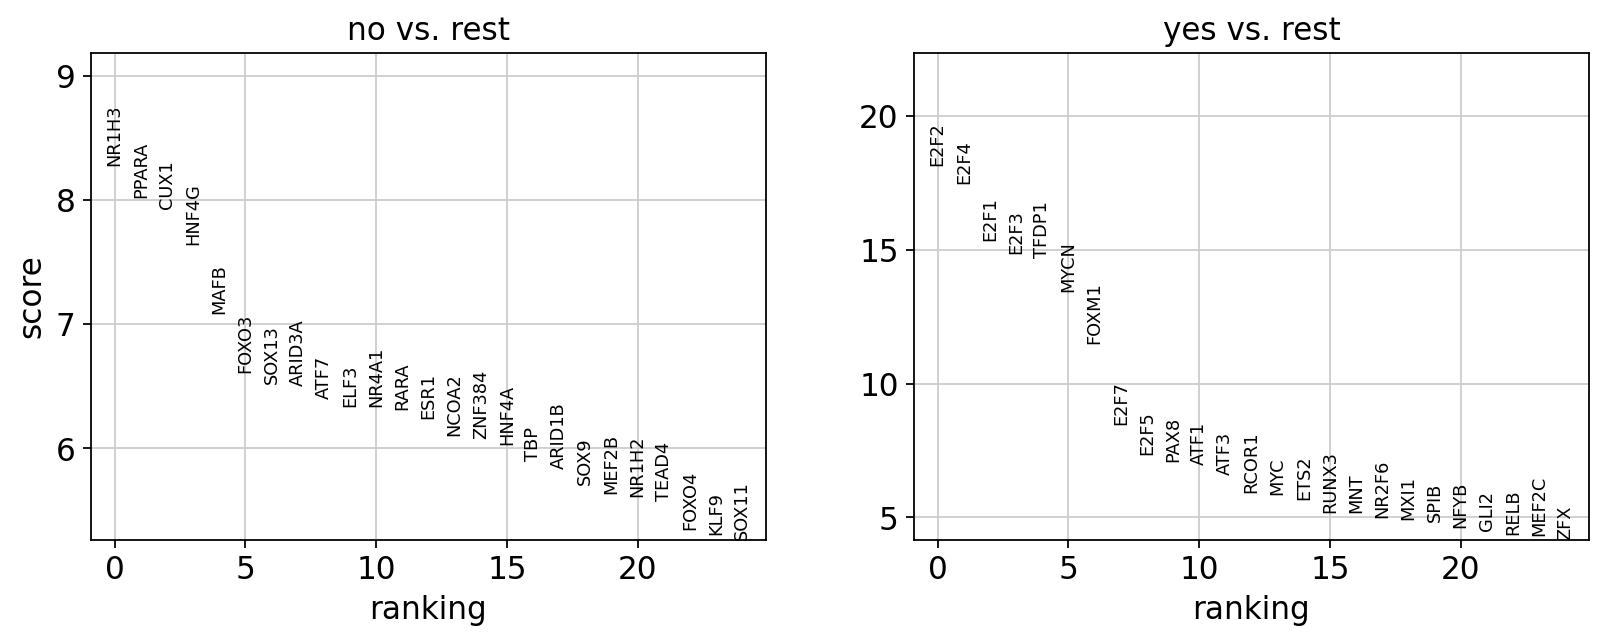

In [53]:
sc.tl.rank_genes_groups(adata, 'cycling', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [54]:
names = adata.uns['rank_genes_groups']['names']
pvals_adj = adata.uns['rank_genes_groups']['pvals_adj']


names_no, names_yes = [x for x in zip(*names)]
pvals_adj_no, pvals_adj_yes = [x for x in zip(*pvals_adj)]


cyc_adata = adata[adata.obs.cycling == 'yes']
noncyc_adata = adata[adata.obs.cycling == 'no']
mean_cyc = np.mean(cyc_adata.X, axis=0)
mean_noncyc = np.mean(noncyc_adata.X, axis=0)
diff_means = np.array(mean_cyc - mean_noncyc)


df_yes = pd.DataFrame()
df_yes['gene'] = names_yes
df_yes['pvals_adj'] = pvals_adj_yes

diffs = []
for name in names_yes:
    idx = list(adata.var.index).index(name)
    diffs.append(diff_means[idx])
df_yes['diff_mean'] = diffs
df_yes.head(15)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


gene     pvals_adj  diff_mean
0    E2F2  3.177161e-71   1.688129
1    E2F4  4.871912e-66   3.117788
2    E2F1  4.012616e-51   2.302816
3    E2F3  4.242155e-48   1.318561
4   TFDP1  3.111996e-47   1.649992
5    MYCN  2.402543e-39   1.346120
6   FOXM1  6.061439e-29   0.973104
7    E2F7  8.926311e-16   0.792639
8    E2F5  5.548509e-12   0.710021
9    PAX8  2.856817e-11   0.436050
10   ATF1  6.580695e-11   0.454264
11   ATF3  6.880710e-10   0.934307
12  RCOR1  3.484489e-08   0.771851
13    MYC  4.537816e-08   0.793075
14   ETS2  1.408010e-07   0.381248

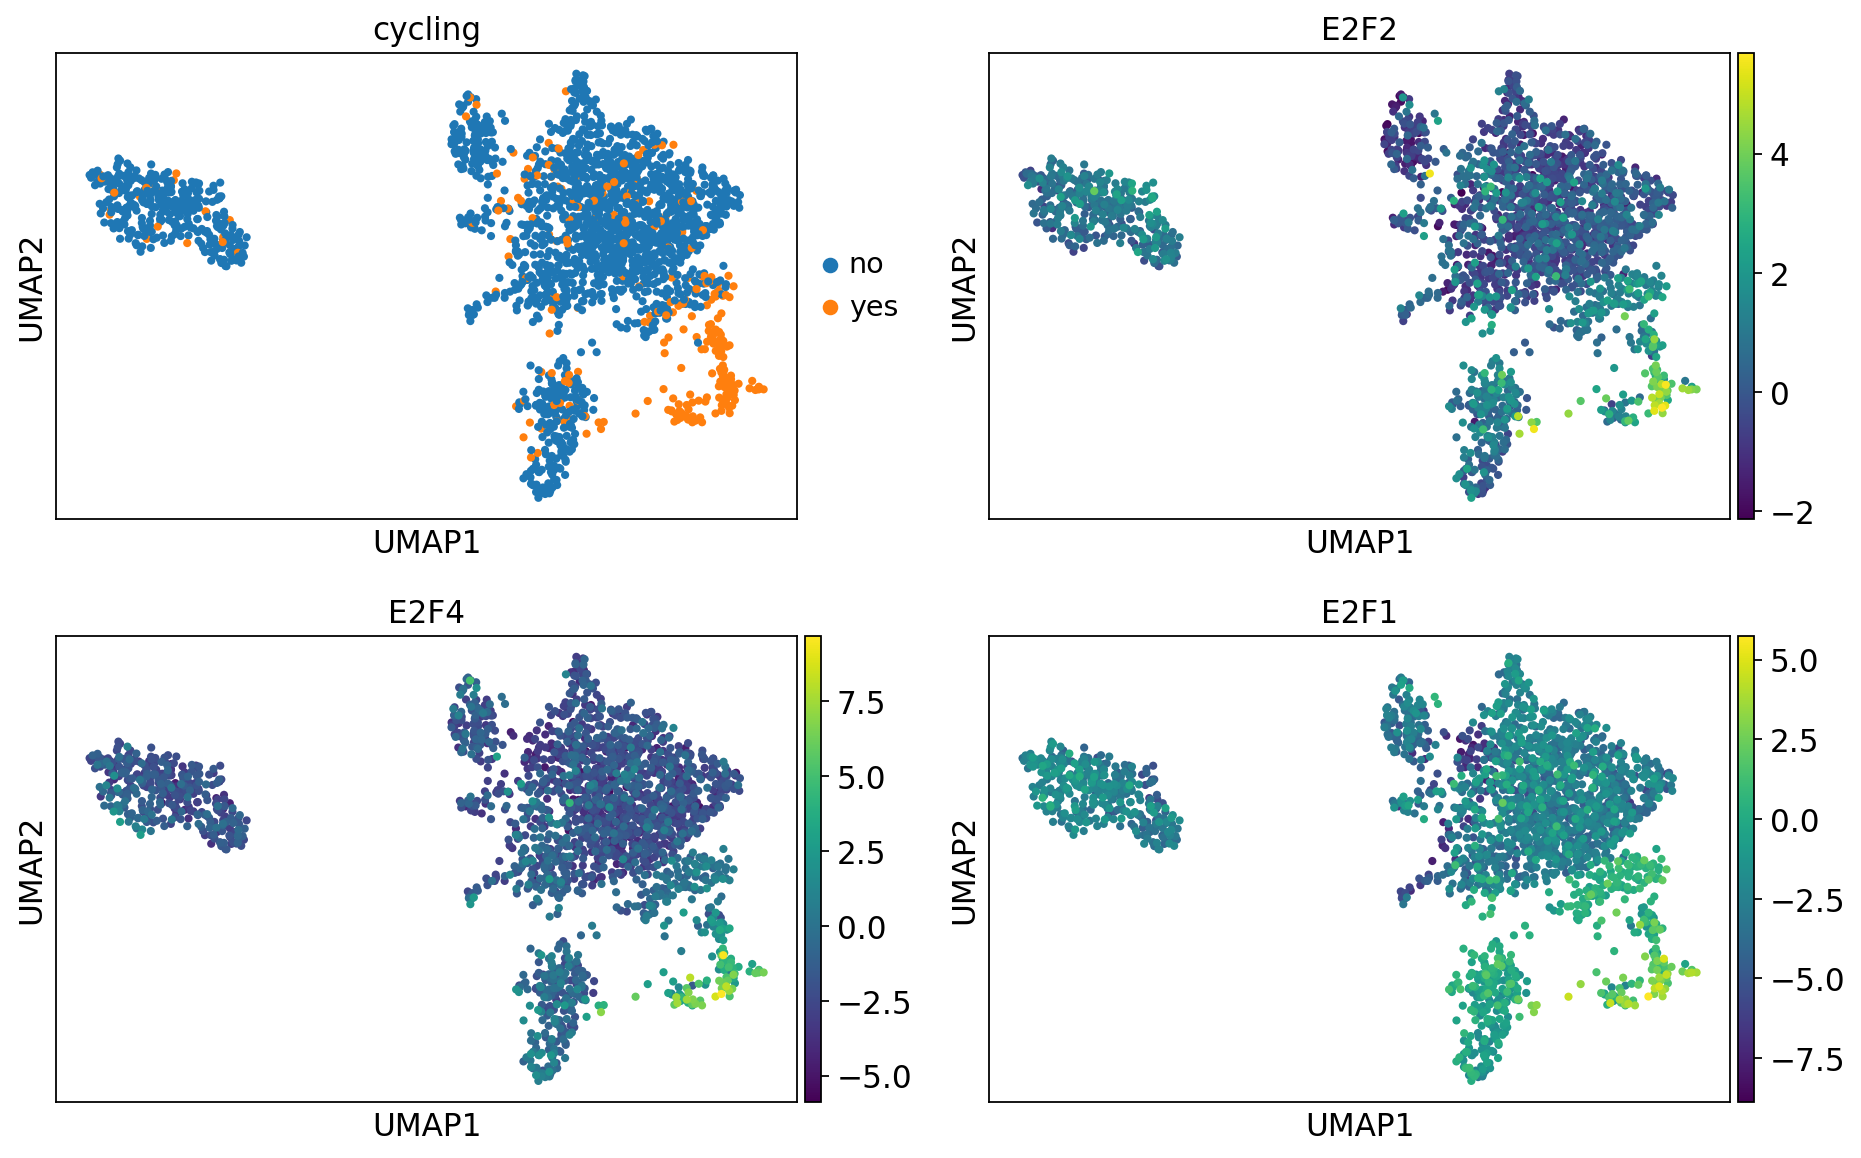

In [56]:
sc.pl.umap(adata, color=['cycling'] + list(df_yes.head(3).gene), ncols=2)

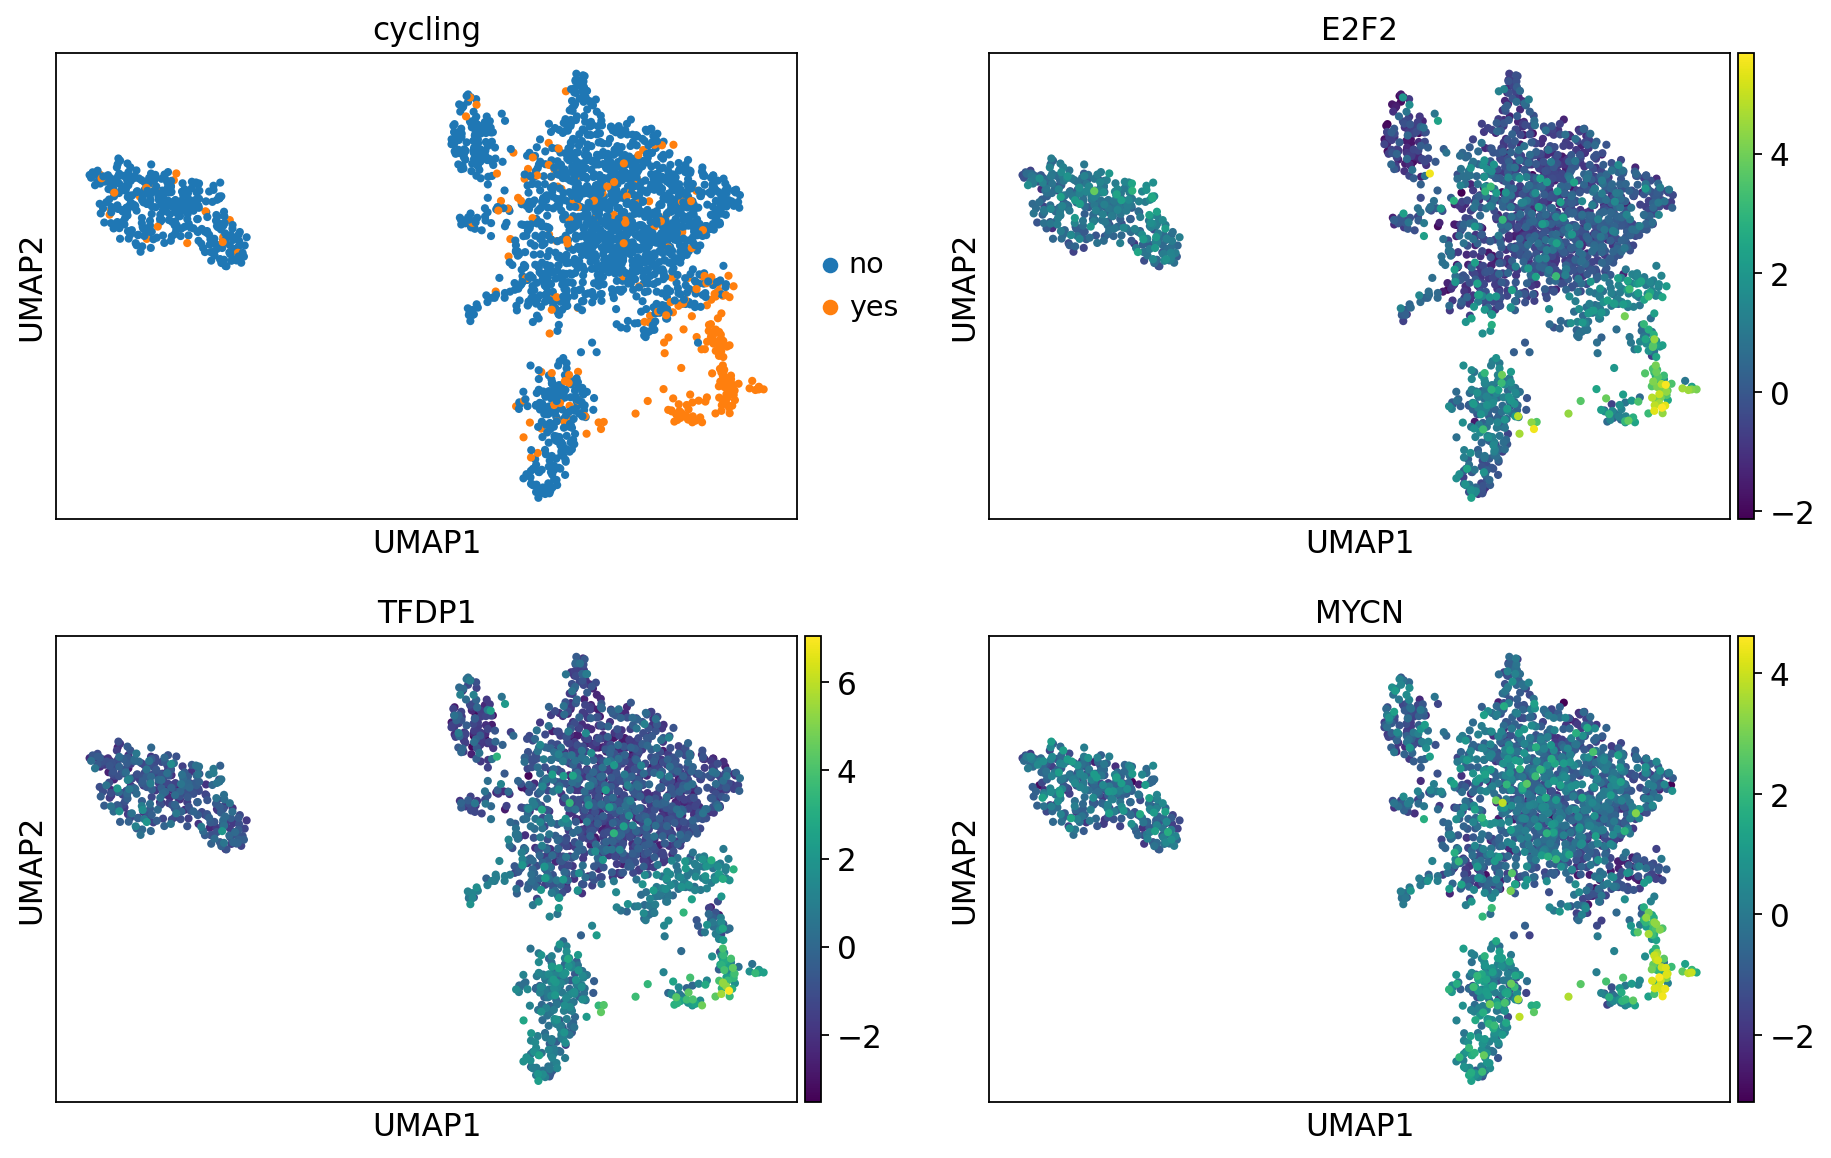

In [57]:
sc.pl.umap(adata, color=['cycling'] + ['E2F2', 'TFDP1', 'MYCN'], ncols=2)

# PROGENy

In [39]:
df = pd.read_csv('data/rna_seq/progeny.csv', index_col=0)
meta = pd.read_csv('data/rna_seq/metadata.csv', index_col=0)
meta['donor'] = [name.split('_')[0] for name in meta.index]


adata = anndata.AnnData(df)
adata.obs = pd.merge(adata.obs, meta, left_index=True,right_index=True)
sorted_idx = np.argsort(h_adata.obs.index)
adata.obsm['X_umap'] = h_adata.obsm['X_umap'][sorted_idx]
sc.pp.scale(adata, max_value=10)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'broad_celltype' as categorical
... storing 'cycling' as categorical
... storing 'donor' as categorical


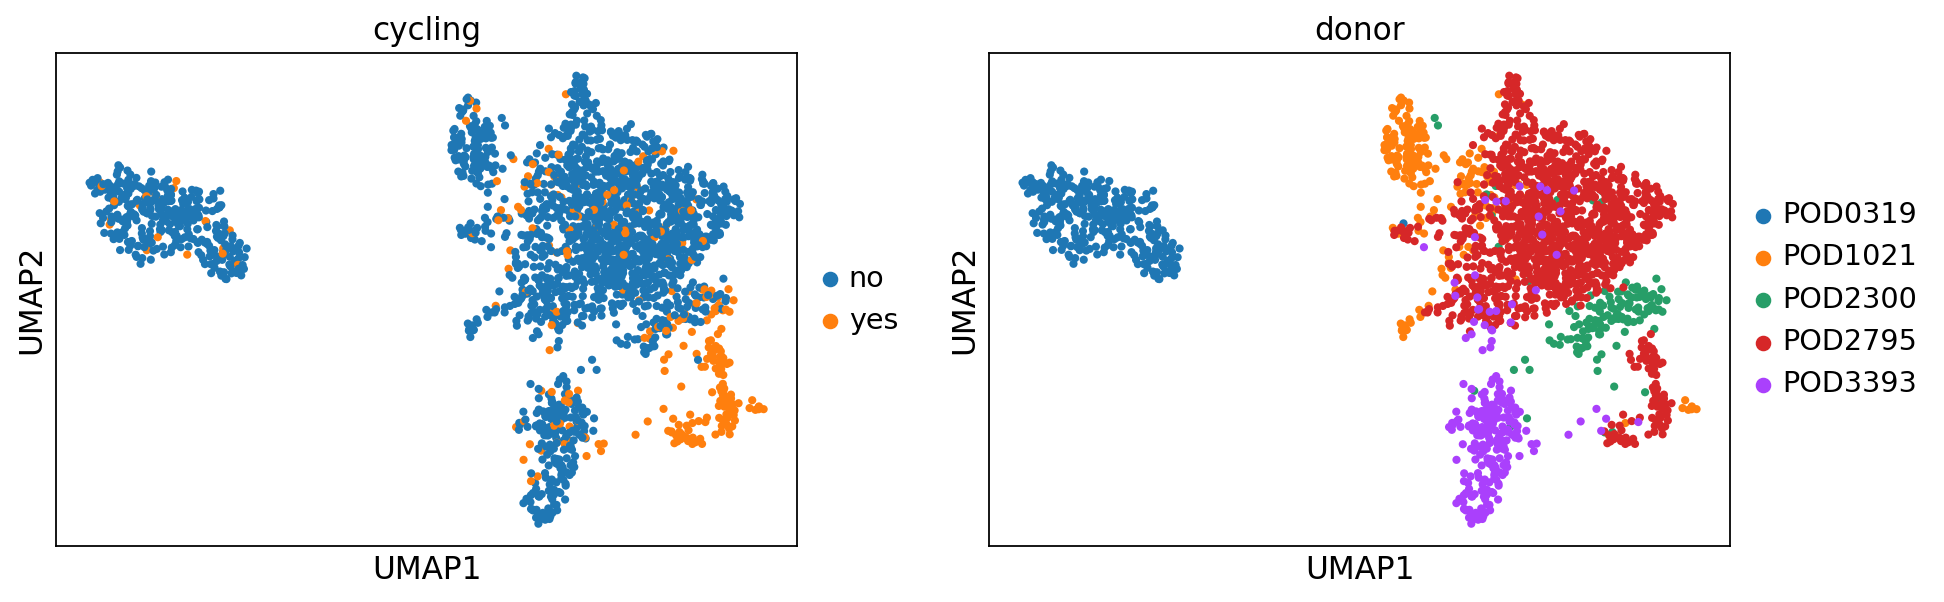

In [40]:
sc.pl.umap(adata, color=['cycling', 'donor'])

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


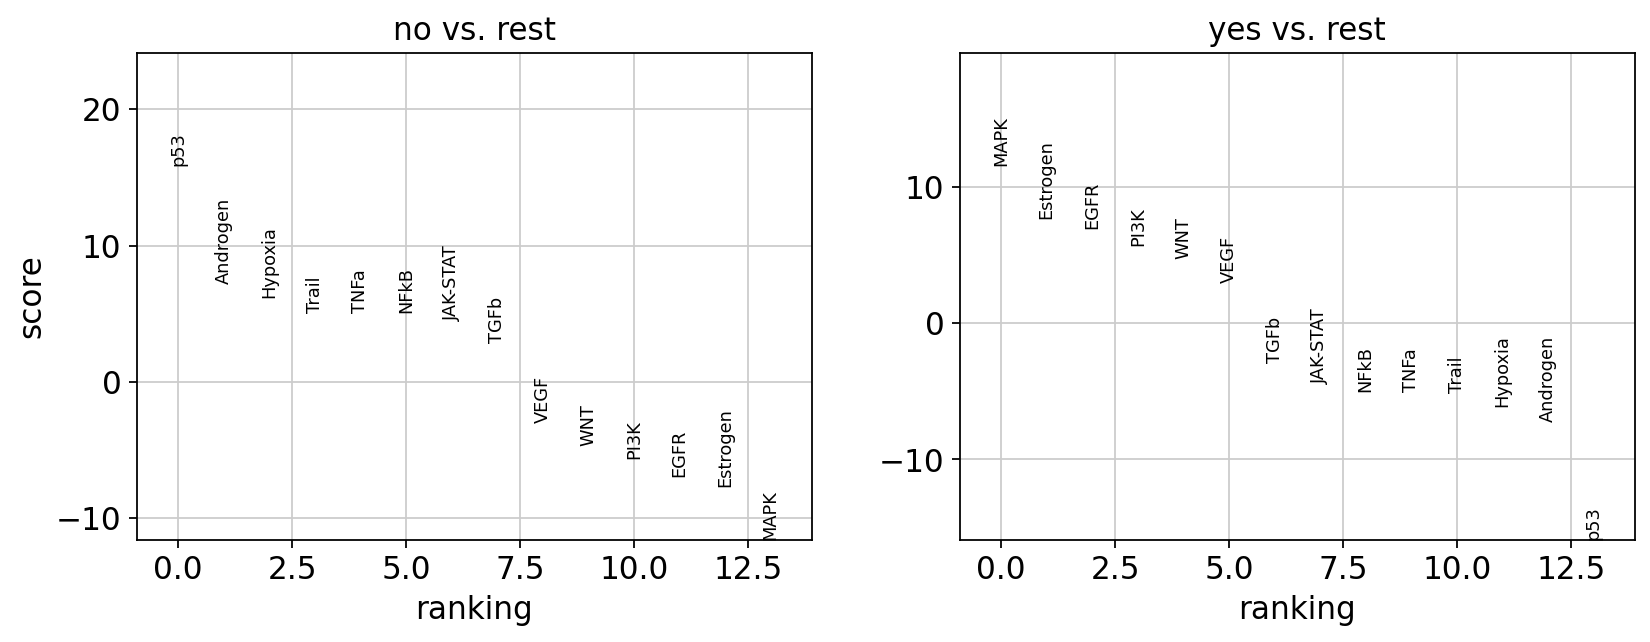

In [41]:
sc.tl.rank_genes_groups(adata, 'cycling', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=14, sharey=False)

In [42]:
names = adata.uns['rank_genes_groups']['names']
pvals_adj = adata.uns['rank_genes_groups']['pvals_adj']


names_no, names_yes = [x for x in zip(*names)]
pvals_adj_no, pvals_adj_yes = [x for x in zip(*pvals_adj)]


cyc_adata = adata[adata.obs.cycling == 'yes']
noncyc_adata = adata[adata.obs.cycling == 'no']
mean_cyc = np.mean(cyc_adata.X, axis=0)
mean_noncyc = np.mean(noncyc_adata.X, axis=0)
diff_means = np.array(mean_cyc - mean_noncyc)


df_yes = pd.DataFrame()
df_yes['gene'] = names_yes
df_yes['pvals_adj'] = pvals_adj_yes

diffs = []
for name in names_yes:
    idx = list(adata.var.index).index(name)
    diffs.append(diff_means[idx])
df_yes['diff_mean'] = diffs
df_yes.head(14)

/home/badi/anaconda3/envs/ml/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


gene     pvals_adj  diff_mean
0       MAPK  3.244953e-30   0.840059
1   Estrogen  6.363348e-14   0.530766
2       EGFR  9.525992e-12   0.481462
3       PI3K  2.590787e-08   0.401986
4        WNT  2.871990e-06   0.301687
5       VEGF  2.932689e-03   0.206163
6       TGFb  3.843857e-03  -0.259722
7   JAK-STAT  1.049836e-05  -0.243307
8       NFkB  5.866039e-07  -0.287770
9       TNFa  5.866039e-07  -0.285273
10     Trail  5.866039e-07  -0.324323
11   Hypoxia  1.589124e-09  -0.394948
12  Androgen  1.835640e-12  -0.530518
13       p53  1.195702e-55  -1.468463

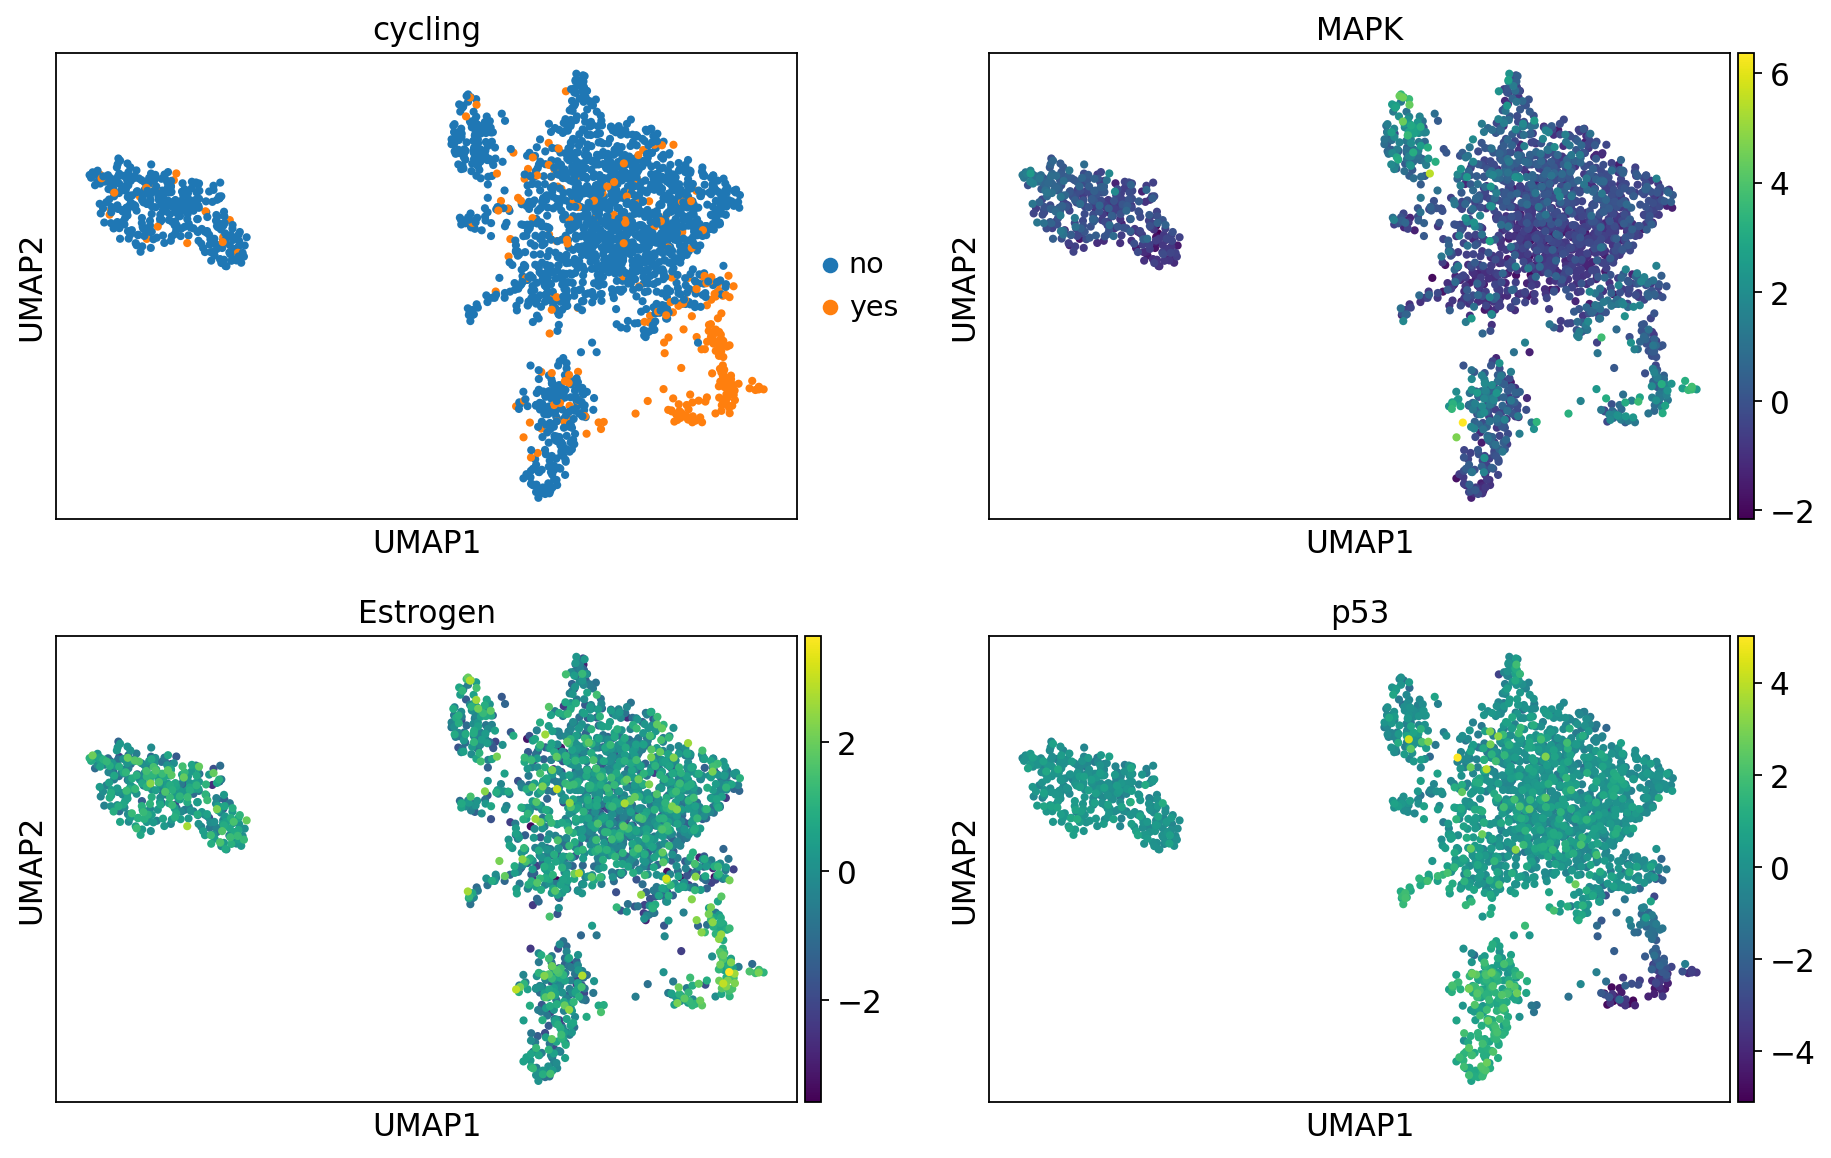

In [49]:
sc.pl.umap(adata, color=['cycling'] + ['MAPK', 'Estrogen', 'p53'], ncols=2)

# Visum

In [13]:
def get_adata(path, meta):
    sample = ''.join(path.split('/')[2].split('_')[-2:])
    adata = sc.read_visium(path)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=10)
    
    adata.obs.index = [sample + '_' + name for name in adata.obs.index]
    msk = [name in meta.index for name in adata.obs.index]
    adata = adata[msk]
    adata.obs = pd.merge(adata.obs, meta, left_index=True,right_index=True)
    
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata

root_path = 'data/'
rna_path = root_path + 'visum/'
lst_dirs = [dname for dname in os.listdir(rna_path) if os.path.isdir(rna_path+dname) and dname.startswith('2')]

meta = pd.read_csv('data/visum/metadata.csv', index_col=0)

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = rna_path + d + '/outs/'
    tmp = get_adata(path, meta)
    adatas.append(tmp)
    del tmp

  0%|          | 0/2 [00:00<?, ?it/s]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
 50%|█████     | 1/2 [00:01<00:01,  1.29s/it]Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


In [48]:
adata = adatas[1]

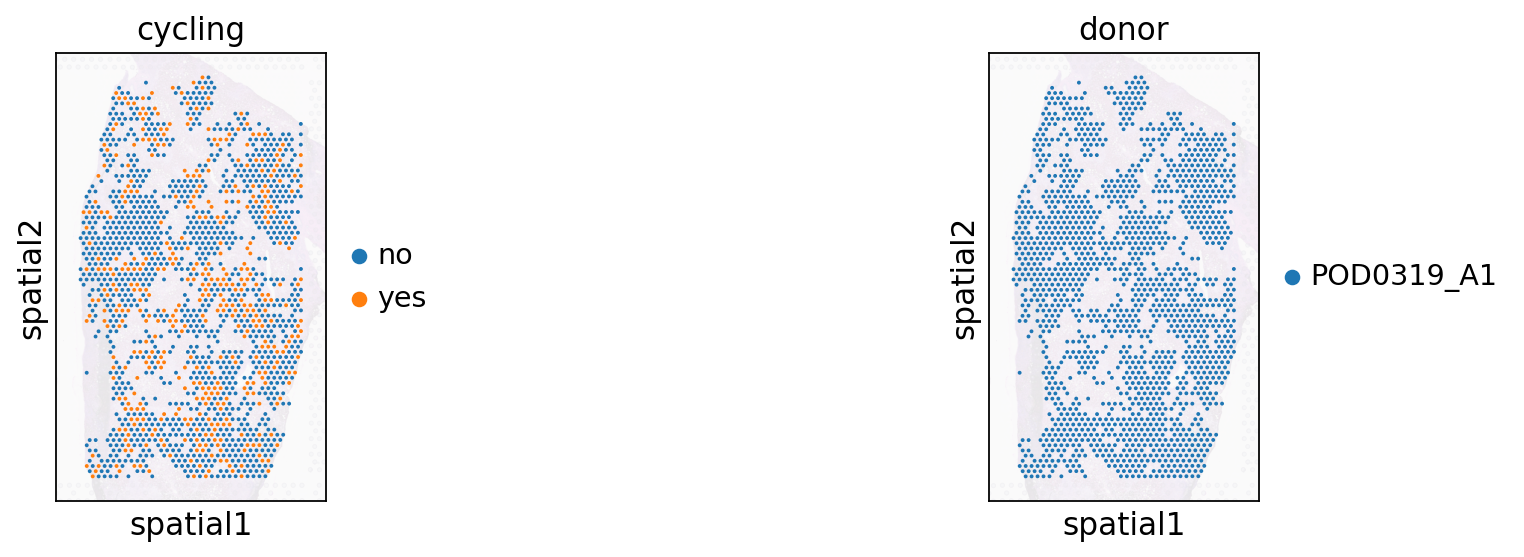

<Figure size 480x320 with 0 Axes>

<Figure size 480x320 with 0 Axes>

In [75]:
sc.pl.spatial(adata, img_key="hires", color=['cycling', 'donor'], alpha_img = 0.1)
plt.tight_layout()
plt.show(0)

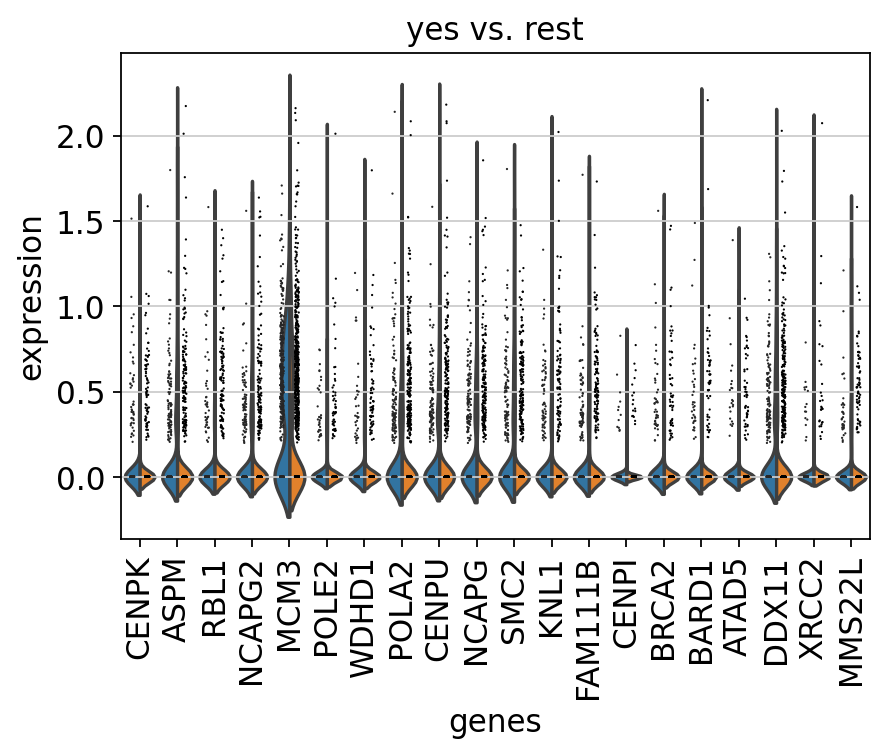

In [73]:
#sc.tl.rank_genes_groups(adata, 'cycling', method='wilcoxon')
sc.pl.rank_genes_groups_violin(adata, gene_names=['CENPK', 'ASPM', 'RBL1', 'NCAPG2', 'MCM3', 'POLE2', 'WDHD1', 'POLA2', 'CENPU', 'NCAPG', 'SMC2', 'KNL1', 'FAM111B', 'CENPI', 'BRCA2', 'BARD1', 'ATAD5', 'DDX11', 'XRCC2', 'MMS22L'], groups=['yes'])

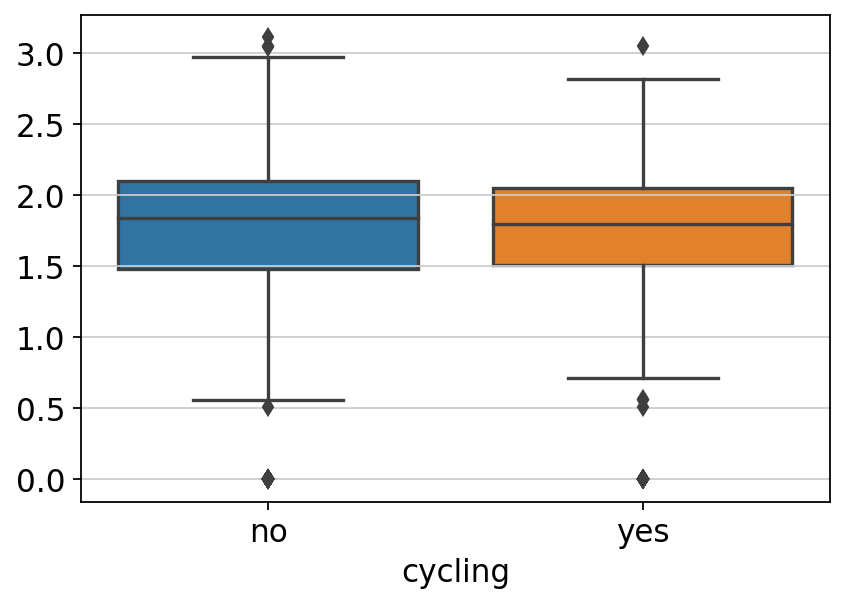

In [58]:
name = 'CYP2C8'

idx = list(adata.var.index).index(name)
val = adata.X[:,idx].toarray().flatten()
cyc = adata.obs.cycling

sns.boxplot(x=cyc, y=val)
plt.show()

11247

In [ ]:
def get_id_ctype(path, adata):
    adata.obs['neil_cell_type'] = ''
    with open(path, 'r') as f:
        f.readline()
        for line in f.readlines():
            cell, ctype = line.rstrip().split(',')
            cell = cell.split('_')[1]
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'neil_cell_type'] = ctype
        
def get_cyc(path, adata):
    adata.obs['cycling'] = 'no'
    with open(path, 'r') as f:
        for line in f.readlines():
            cell, cyc = line.rstrip().split(',')
            cell = cell + '-1'
            if cell in adata.obs.index:
                adata.obs.loc[cell, 'cycling'] = cyc
                
def get_adata(path, cpath, cyc_path):
    adata = sc.read_visium(path)
    adata.var_names_make_unique()
    sc.pp.filter_genes(adata, min_cells=10)
    get_id_ctype(cpath, adata)
    get_cyc(cyc_path, adata)
    adata = adata[adata.obs.neil_cell_type == 'Hepatocytes']
    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    adata.raw = adata
    return adata


visum_path = root_path + 'visum/'
lst_dirs = [dname + '/outs/' for dname in os.listdir(visum_path) if os.path.isdir(visum_path+dname) and dname.startswith('2')]

adatas = []
for i,d in enumerate(tqdm(lst_dirs)):
    path = visum_path + d
    sample = d.split('_')[2]
    subsample = d.split('_')[3][:2]
    path_ctype = visum_path + d + '../{0}{1}_broad_celltype.csv'.format(sample, subsample)
    path_cyc = root_path + 'visum_cycling.csv'
    tmp = get_adata(path, path_ctype, path_cyc)
    sc.pp.highly_variable_genes(tmp, flavor="seurat", n_top_genes=2000)
    adatas.append(tmp)
    del tmp

In [ ]:
sc.pl.spatial(adatas[0], img_key="hires", color=["cycling"],
              frameon=False, alpha_img=0.2, ncols=2)

In [ ]:
del adata

In [ ]:
%%time
counts = pd.DataFrame(adatas[0].X.todense(), columns=adatas[0].var_names, index=adatas[0].obs_names)
coord = pd.DataFrame(adatas[0].obsm['spatial'], columns=['x_coord', 'y_coord'], index=adatas[0].obs_names)
results = SpatialDE.run(coord, counts)

In [ ]:
results.index = results["g"]
adatas[0].var = pd.concat([adatas[0].var, results.loc[adatas[0].var.index.values, :]], axis=1)

In [ ]:
results.sort_values("qval").head(10)

In [ ]:
sc.pl.spatial(adatas[0], img_key="hires", color=["APOA4", "KRT19"], alpha=0.7)